# Constructing dataset of fire incidences and their environmental predictors

Author: Jatan Buch (v1, 231120) || (v2, 231201)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
import re # for regular expressions

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray
import zarr
import xesmf as xe # for regridding
import pickle # for saving and loading models
from pathlib import Path

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# self-libraries
from data_utils import *

from shapely.geometry import Point, mapping, LineString
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

# Environmental predictors

In [51]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

sub = (51.6, -128, 26.5, -101) # North/West/South/East
ds_out = xarray.Dataset(
    {
        "lat": (["lat"], np.arange(26.5, 51.6, 0.125), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(-128, -101, 0.125), {"units": "degrees_west"}),
    }
)

## Vegetation data

In [3]:
casm_ds= xarray.open_dataset('../data/vegetation/casm_for_jatan.nc') #, chunks={"date": 10}

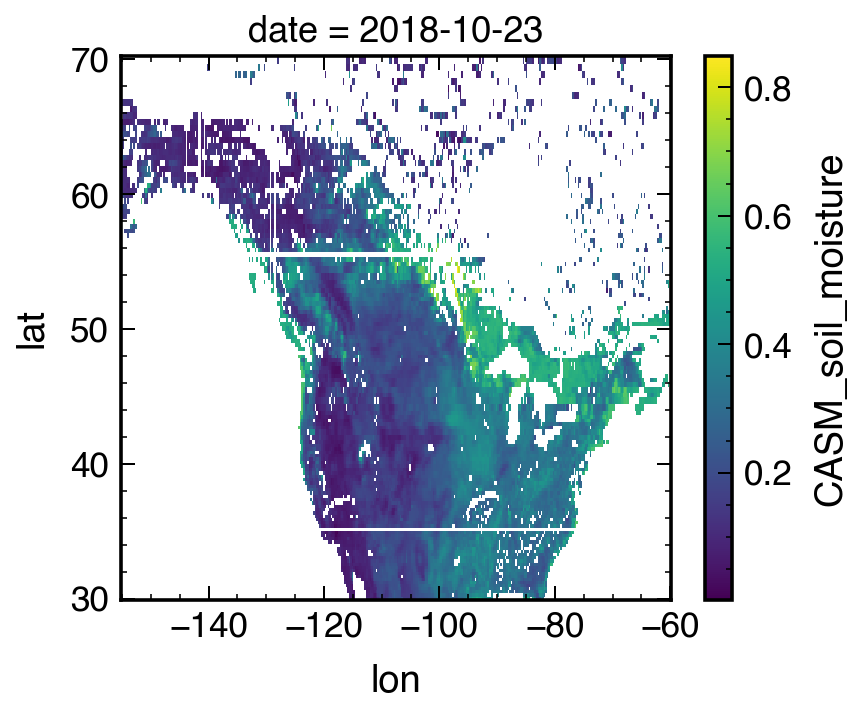

In [71]:
casm_ds.CASM_soil_moisture[1983].plot()

In [4]:
casm_ds_conus_XY= regridding_func(casm_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear')
#casm_ds_conus_XY.to_netcdf('../data/12km/casm_conus_12km.nc')

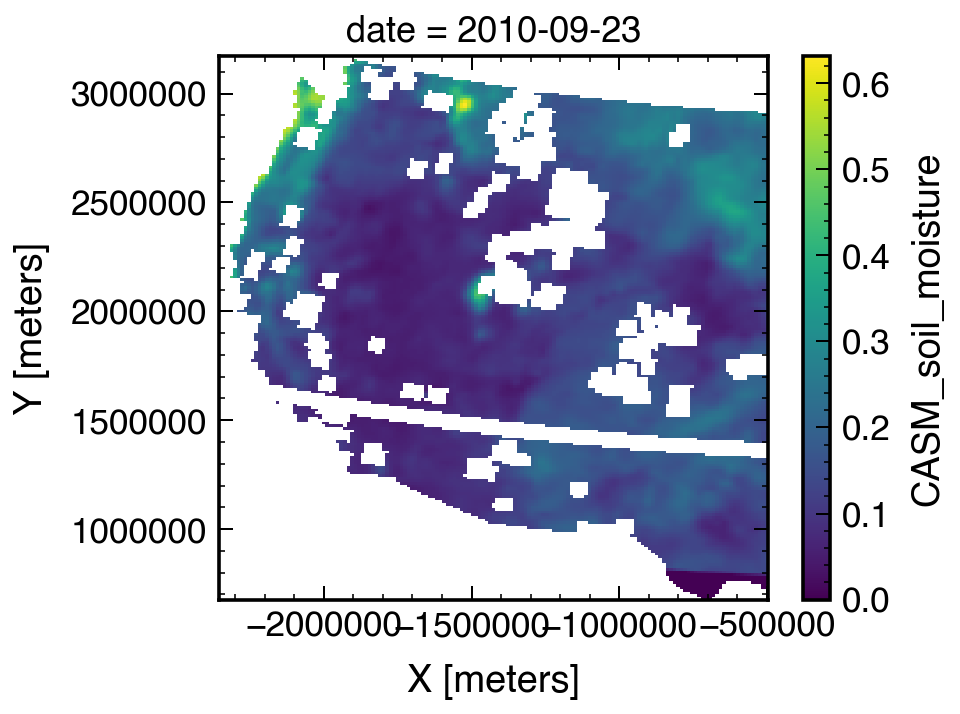

In [5]:
casm_ds_conus_XY.CASM_soil_moisture[1000].plot()

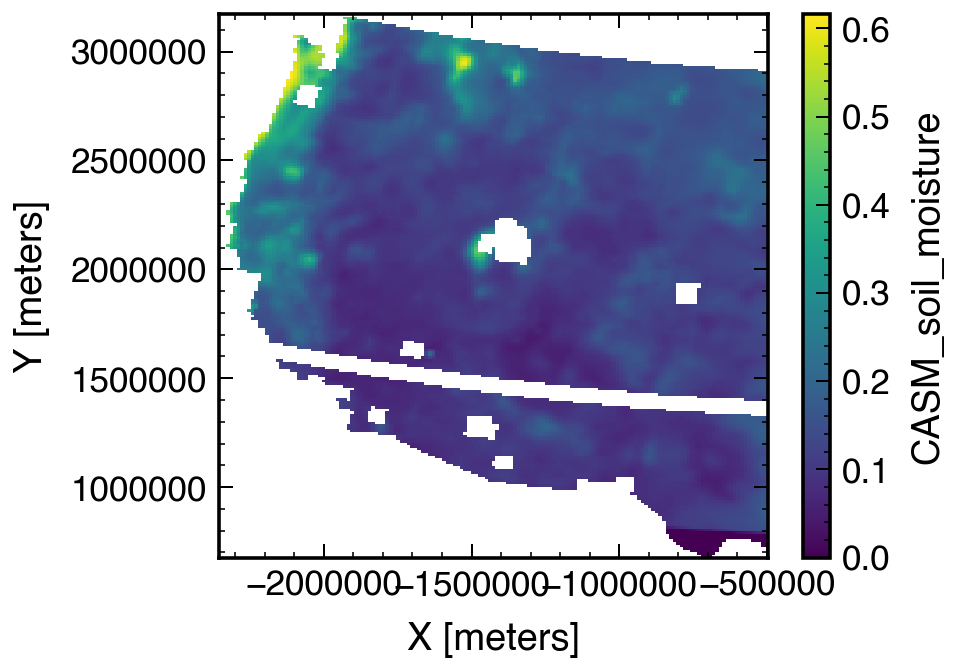

In [64]:
casm_ds_conus_XY.CASM_soil_moisture.mean(dim= 'date').plot()

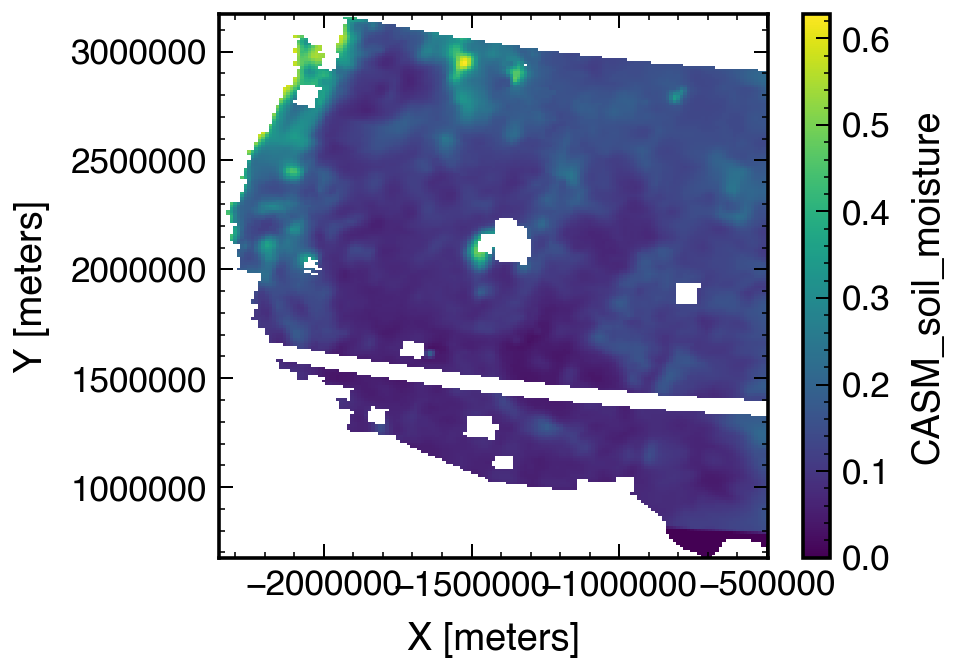

In [67]:
casm_ds_conus_XY.CASM_soil_moisture.sel(date= casm_ds_conus_XY.date.dt.month == 6).mean(dim= 'date').plot()

In [7]:
csif_ds= xarray.open_dataset('../data/vegetation/csif_for_jatan.nc')

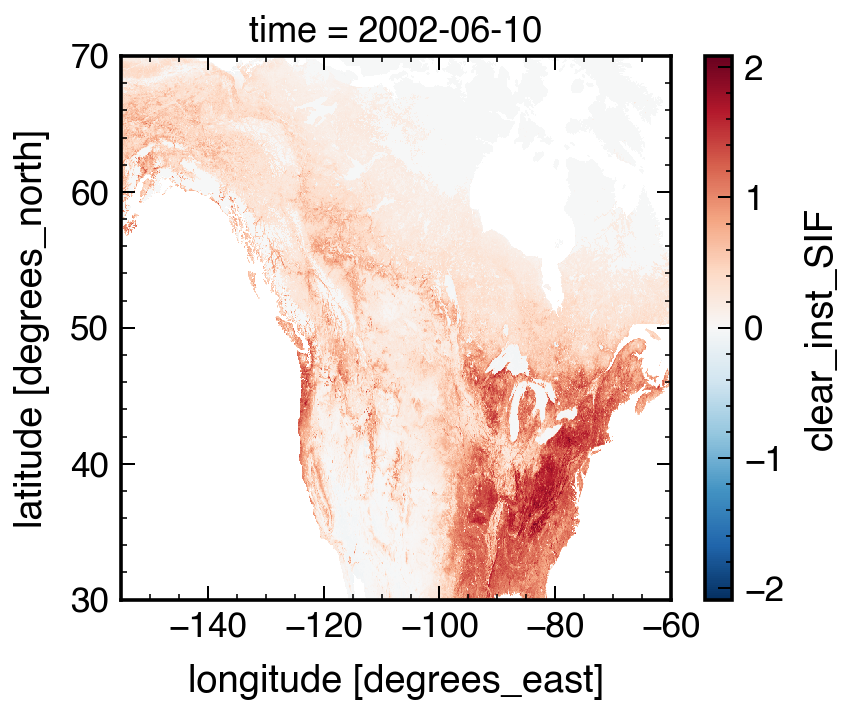

In [9]:
csif_ds.clear_inst_SIF[40].plot()

In [10]:
csif_ds_conus_XY= regridding_func(csif_ds.clear_inst_SIF, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear')
#csif_ds_conus_XY.to_netcdf(''../data/12km/csif_clear_inst_conus_12km.nc')

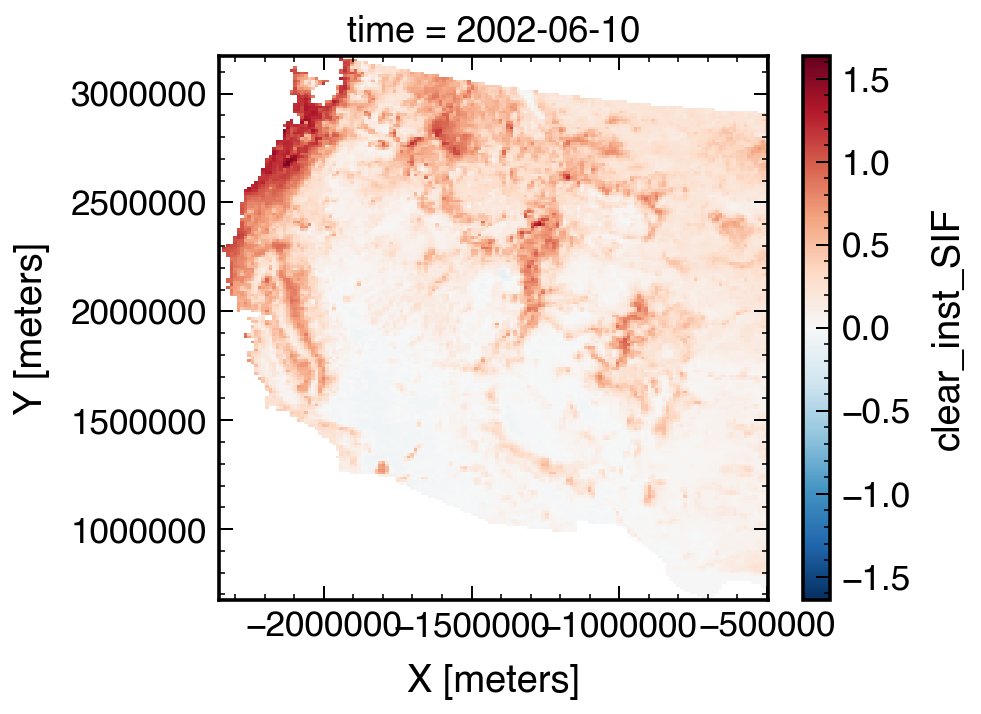

In [11]:
csif_ds_conus_XY[40].plot()

## ERA5 reanalysis data

(Used instead of gridMET for future compatability with Canadian/Australian data as well)

In [49]:
DATADIR = '../data/meteorology'
var_arr= ['2m_dewpoint_temperature', '2m_temperature', 'total_precipitation'] #'10m_u_component_of_wind', '10m_v_component_of_wind',
yr_arr= list(np.arange(2002, 2021).astype(str))

### Hourly data

In [4]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '136899:e611201e-7672-4596-9783-4fc89f7161e3'

In [15]:
ffwi_da= xarray.open_dataarray('../data/meteorology/daily/era5_wus_forecast_hourly_FFWI_2002.grib', engine='cfgrib')

In [19]:
c = cdsapi.Client(url=URL, key=KEY)
for var in var_arr:
    for yr in yr_arr:
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'grib',
                'variable': [var],
                'year': [yr],
                'month': ['02', '03', '04', '05', '06', '07', '08', '09'],
                'day': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                    '13', '14', '15',
                    '16', '17', '18',
                    '19', '20', '21',
                    '22', '23', '24',
                    '25', '26', '27',
                    '28', '29', '30',
                    '31',
                ],
                'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
                'area': [51.6, -128, 26.5, -101],
            },
            f'{DATADIR}hourly/era5_wus_forecast_hourly_%s'%var + f'_%s.grib'%yr)

2023-11-21 09:23:23,456 INFO Welcome to the CDS
2023-11-21 09:23:23,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-21 09:23:23,684 INFO Request is queued
2023-11-21 09:27:43,015 INFO Request is running
2023-11-21 09:31:43,950 INFO Request is completed
2023-11-21 09:31:43,952 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.internal-1700576850.5966997-16543-1-dd2a740b-7b32-411b-a01c-670f7963d64e.grib to ../data/meteorology//era5_wus_forecast_hourly_2m_dewpoint_temperature_2020.grib (123.5M)
2023-11-21 09:32:01,091 INFO Download rate 7.2M/s  
2023-11-21 09:32:01,315 INFO Welcome to the CDS
2023-11-21 09:32:01,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-21 09:32:01,448 INFO Request is queued
2023-11-21 09:36:20,931 INFO Request is running
2023-11-21 09:38:21,409 INFO Request is completed
2023-

In [20]:
ds= xarray.open_dataset(f'{DATADIR}hourly/era5_wus_forecast_hourly_2m_temperature_2002.grib', engine='cfgrib')

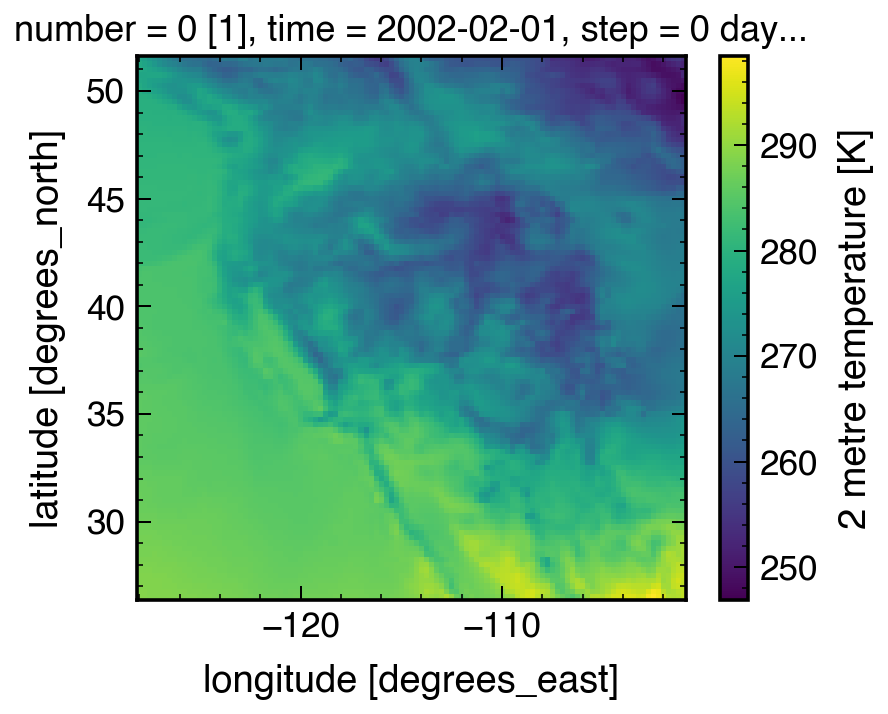

In [27]:
ds.t2m[0].plot()

### Daily data

In [19]:
c = cdsapi.Client(url=URL, key=KEY)
for yr in yr_arr:
    c.retrieve(
        'cems-fire-historical-v1',
        {
            'product_type': 'reanalysis',
            'format': 'grib',
            'variable': 'fire_weather_index',
            'year': [yr],
            'month': ['02', '03', '04', '05', '06', '07', '08', '09'],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'grid': '0.25/0.25',
            'area': [51.6, -128, 26.5, -101],
        },
        f'{DATADIR}/daily/era5_wus_forecast_daily_FFWI_%s.grib'%yr)

2023-11-30 11:59:22,955 INFO Welcome to the CDS
2023-11-30 11:59:22,956 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-fire-historical-v1
2023-11-30 11:59:23,108 INFO Request is queued
2023-11-30 11:59:24,227 INFO Request is completed
2023-11-30 11:59:24,227 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data9/adaptor.mars.external-1701363336.4815354-8507-2-48c30c03-34ec-453f-90d9-87d71d6f8e1c.grib to ../data/meteorology/daily/era5_wus_forecast_daily_FFWI_2002.grib (4.3M)
2023-11-30 11:59:25,581 INFO Download rate 3.2M/s   
2023-11-30 11:59:25,794 INFO Welcome to the CDS
2023-11-30 11:59:25,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-fire-historical-v1
2023-11-30 11:59:25,942 INFO Request is queued
2023-11-30 11:59:27,059 INFO Request is running
2023-11-30 11:59:39,706 INFO Request is completed
2023-11-30 11:59:39,707 INFO Downloading https://download-0013-clone.coperni

In [29]:
ffwi_da= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_FFWI_2002-2020.nc')

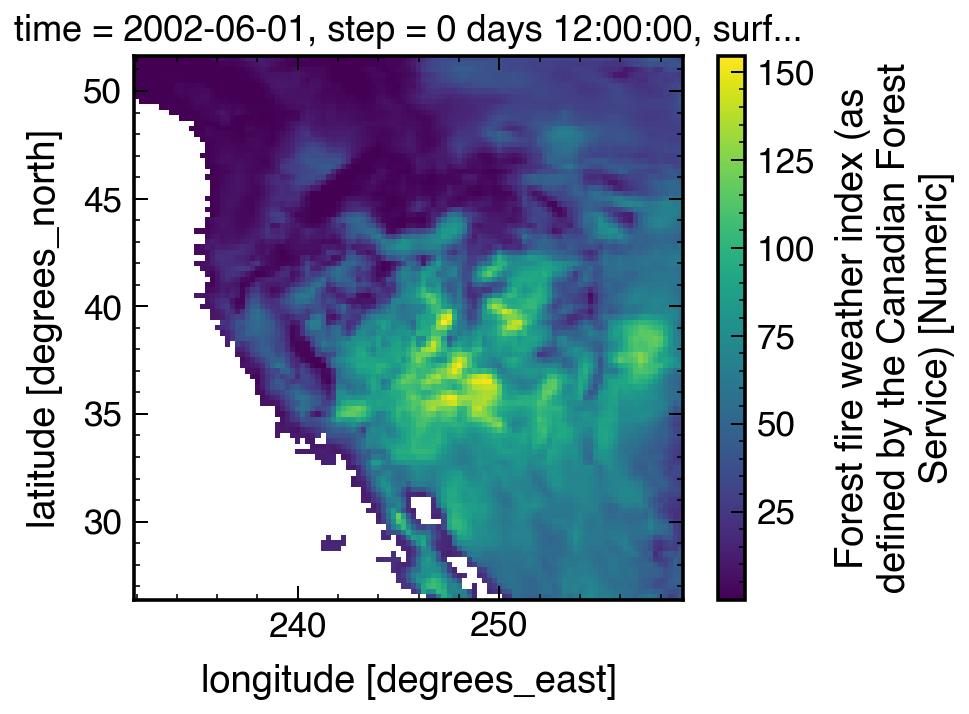

In [32]:
ffwi_da[120].plot()

In [93]:
load_daily_meteorlogical_predictors(var= '2m_dewpoint_temperature', yrarr= yr_arr, datadir= DATADIR, maxmin_arg= 'max')

100%|██████████| 19/19 [01:21<00:00,  4.26s/it]


In [175]:
load_daily_meteorlogical_predictors(var= 'total_precipitation', yrarr= yr_arr, datadir= DATADIR)

100%|██████████| 19/19 [00:55<00:00,  2.90s/it]


### Regridded data

In [5]:
tmax_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_Tmax_2002-2020.nc')
tmax_ds_conus_XY= regridding_func(tmax_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tmax_ds_conus_XY= tmax_ds_conus_XY.drop(['number', 'step', 'surface'])
tmax_ds_conus_XY.to_netcdf('../data/12km/Tmax_daily_conus_2002-2020_12km.nc')

tmin_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_Tmin_2002-2020.nc')
tmin_ds_conus_XY= regridding_func(tmin_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tmin_ds_conus_XY= tmin_ds_conus_XY.drop(['number', 'step', 'surface'])
tmin_ds_conus_XY.to_netcdf('../data/12km/Tmin_daily_conus_2002-2020_12km.nc')

prec_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_Prec_2002-2020.nc')
prec_ds_conus_XY= regridding_func(prec_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
prec_ds_conus_XY= prec_ds_conus_XY.drop(['number', 'surface'])
prec_ds_conus_XY.to_netcdf('../data/12km/Prec_daily_conus_2002-2020_12km.nc')

vpd_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_VPD_2002-2020.nc')
vpd_ds_conus_XY= regridding_func(vpd_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
vpd_ds_conus_XY= vpd_ds_conus_XY.drop(['number', 'step', 'surface'])
vpd_ds_conus_XY.to_netcdf('../data/12km/VPD_daily_conus_2002-2020_12km.nc')

ffwi_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_FFWI_2002-2020.nc')
ffwi_ds_conus_XY= regridding_func(ffwi_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
ffwi_ds_conus_XY= ffwi_ds_conus_XY.drop(['valid_time', 'step', 'surface'])
ffwi_ds_conus_XY.to_netcdf('../data/12km/FFWI_daily_conus_2002-2020_12km.nc')

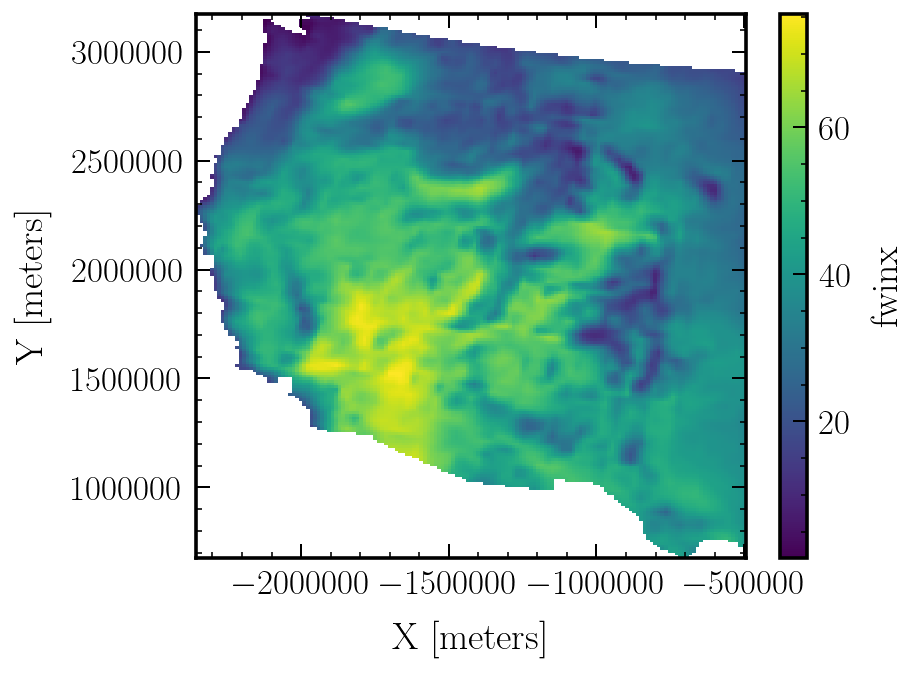

In [10]:
ffwi_da= xarray.open_dataarray('../data/12km/FFWI_daily_conus_2002-2020_12km.nc')
ffwi_da.sel(time= ffwi_da.time.dt.month.isin([6, 7, 8])).mean(dim= 'time').plot()

# Fire perimeters

In [3]:
# Although both gpkg and shapefiles are provided, we will use the gpkg files as they contain all the information in one place

# fire_gdf= gpd.read_file('../data/fire/fired_conus-ak_nov2001-march2021/fired_conus-ak_daily_nov2001-march2021.gpkg')
# eventsdf= fire_gdf.to_crs('5070')

# eventsdf[eventsdf.ig_year > 2001][eventsdf.lc_mode.isin([1, 2, 3, 4, 5, 8])].to_file('../data/fire/fired_conus-ak_2002-2021_forests.gpkg', driver='GPKG')
# eventsdf[eventsdf.ig_year > 2001][eventsdf.lc_mode.isin([6, 7])].to_file('../data/fire/fired_conus-ak_2002-2021_shrubland.gpkg', driver='GPKG')
# eventsdf[eventsdf.ig_year > 2001][eventsdf.lc_mode.isin([9, 10])].to_file('../data/fire/fired_conus-ak_2002-2021_grassland.gpkg', driver='GPKG')

In [2]:
forests_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_forests.gpkg')
shrubland_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_shrubland.gpkg')
grassland_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_grassland.gpkg')

## CONUS BA summary plot

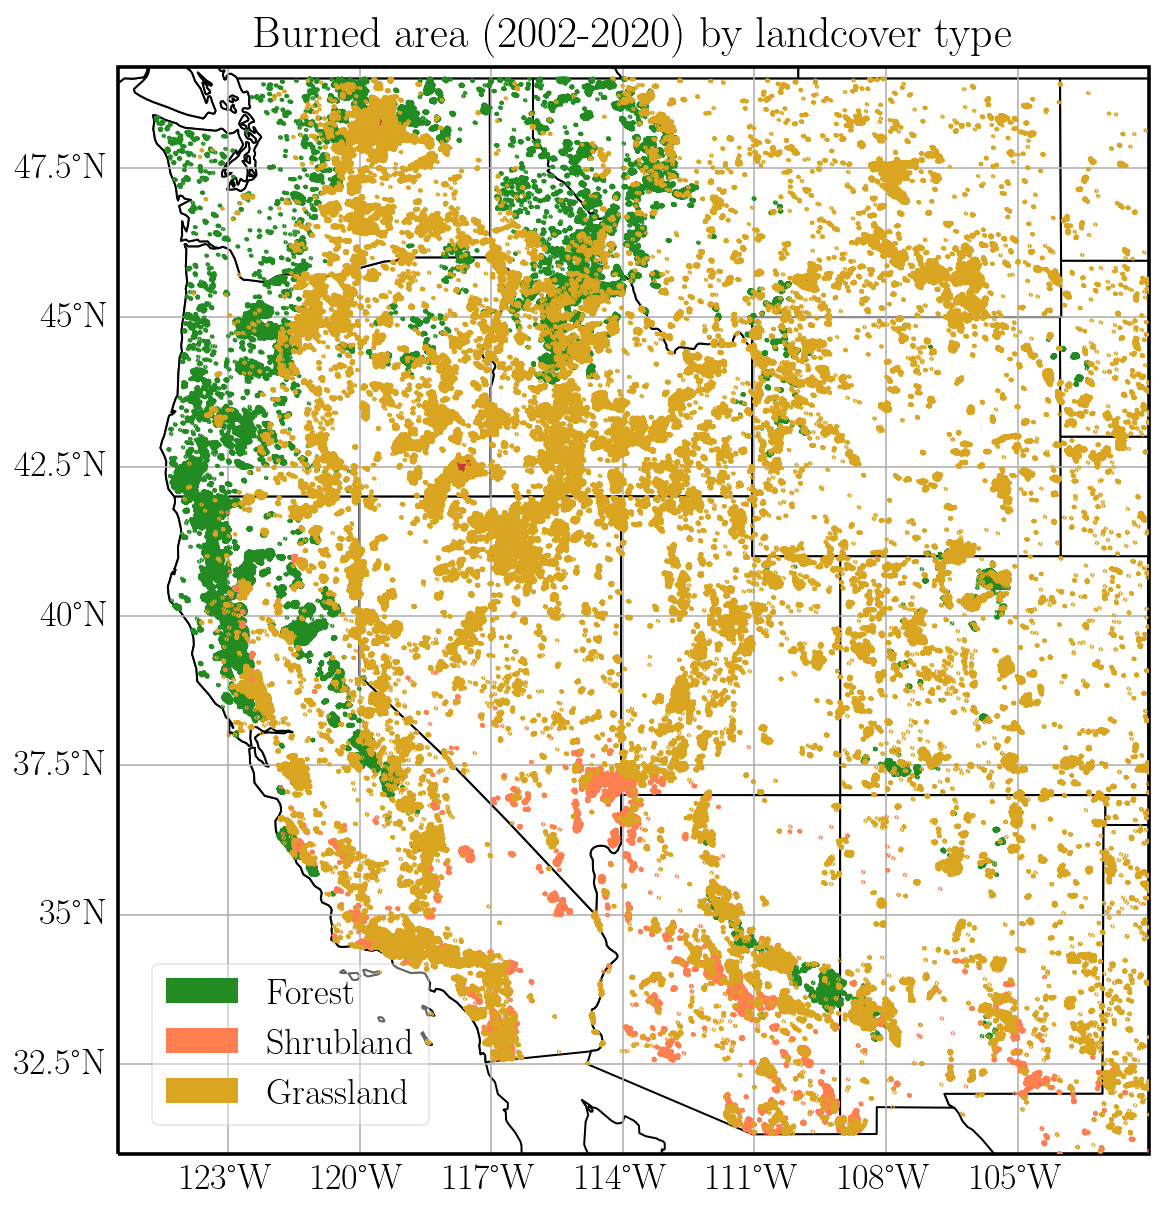

In [28]:
extent = [-125.5, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor= 'white', zorder= 1);
ax.add_geometries(forests_gdf.geometry.to_crs('4326'), crs= ccrs.PlateCarree(), edgecolor= colors.to_rgba('forestgreen', alpha= 1.0), lw= 2, zorder= 10)
ax.add_geometries(shrubland_gdf.geometry.to_crs('4326'), crs= ccrs.PlateCarree(), edgecolor= colors.to_rgba('coral', alpha= 1.0), lw= 2, zorder= 10)
ax.add_geometries(grassland_gdf.geometry.to_crs('4326'), crs= ccrs.PlateCarree(), edgecolor= colors.to_rgba('goldenrod', alpha= 1.0), lw= 2, zorder= 10)
#ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree())
ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False

forest_leg = patches.Rectangle((0, 0), 1, 1, facecolor="forestgreen")
shrub_leg = patches.Rectangle((0, 0), 1, 1, facecolor="coral")
grass_leg = patches.Rectangle((0, 0), 1, 1, facecolor="goldenrod")
labels = ['Forest', 'Shrubland', 'Grassland']
ax.legend([forest_leg, shrub_leg, grass_leg], labels, loc='lower left', bbox_to_anchor=(0.015, 0.01), fontsize= 18, frameon=True)

ax.set_aspect(1.362/1)
ax.set_title(r'Burned area (2002-2020) by landcover type', fontsize= 22, pad= 10);
plt.savefig('../plots/ba_conus_2002-2020.png', bbox_inches='tight', dpi= 200);

## Rasterizing daily BA perimeters

In [3]:
# init_fire_counts_raster(start_date= '2002-01-01', end_date= '2021-05-01', sav_flag= True) # for intializing the raster

# convert ignition date into number of days since 2002-01-01
forests_gdf['ig_day']= (pd.to_datetime(forests_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
forests_gdf['event_ig_day'] = forests_gdf['event_day'] + forests_gdf['ig_day'] - 1
grassland_gdf['ig_day']= (pd.to_datetime(grassland_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
grassland_gdf['event_ig_day'] = grassland_gdf['event_day'] + grassland_gdf['ig_day'] - 1
shrubland_gdf['ig_day']= (pd.to_datetime(shrubland_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
shrubland_gdf['event_ig_day'] = shrubland_gdf['event_day'] + shrubland_gdf['ig_day'] - 1

In [4]:
shrubland_xarr= init_fire_alloc_gdf(lcgdf= shrubland_gdf)
shrubland_xarr.to_netcdf('../data/12km/shrubland_burned_area_2002-2021_12km.nc')
forest_xarr= init_fire_alloc_gdf(lcgdf= forests_gdf)
forest_xarr.to_netcdf('../data/12km/forest_burned_area_2002-2021_12km.nc')
grassland_xarr= init_fire_alloc_gdf(lcgdf= grassland_gdf)
grassland_xarr.to_netcdf('../data/12km/grassland_burned_area_2002-2021_12km.nc')

100%|██████████| 90539/90539 [00:42<00:00, 2135.87it/s]


# Data summary

In [5]:
firemons_arr= np.array([2, 3, 4, 5, 6, 7, 8, 9])

sm_data_ur= xarray.open_dataset('../data/12km/casm_conus_12km.nc').CASM_soil_moisture
sm_data= sm_data_ur.sel(date = sm_data_ur.date.dt.month.isin(firemons_arr))
sm_data= sm_data.interpolate_na(dim= 'date', fill_value= 'extrapolate') # interpolating missing values

csif_data_ur= xarray.open_dataarray('../data/12km/csif_clear_inst_conus_12km.nc')
csif_data= csif_data_ur.sel(time = csif_data_ur.time.dt.month.isin(firemons_arr)).interp(time= sm_data.date.values)

tmax_data= xarray.open_dataarray('../data/12km/Tmax_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 
tmin_data= xarray.open_dataarray('../data/12km/Tmin_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 
prec_data= xarray.open_dataarray('../data/12km/Prec_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 
vpd_data= xarray.open_dataarray('../data/12km/VPD_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 

### Fire growth animation

In [6]:
forest_xarr_ur= xarray.open_dataarray('../data/12km/forest_burned_area_2002-2021_12km.nc') 
forest_xarr= forest_xarr_ur.sel(time= forest_xarr_ur.time.isin(pd.date_range(start= '2002-06-19', end= '2020-09-01', freq= 'D')))
forest_df= forest_xarr.to_dataframe('fire').reset_index()
forest_df['tot_days']= (forest_df.time - pd.to_datetime('2002-01-01')).dt.days

In [7]:
forests_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_forests.gpkg')
forests_gdf['ig_day']= (pd.to_datetime(forests_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
forests_gdf['event_ig_day'] = forests_gdf['event_day'] + forests_gdf['ig_day'] - 1

In [8]:
forests_gdf.sort_values(by= 'tot_ar_km2', ascending= False)[['id', 'ig_day', 'event_ig_day', 'dy_ar_km2', 'tot_ar_km2', 'geometry']][60:].head(20)

,id,ig_day,event_ig_day,dy_ar_km2,tot_ar_km2,geometry
97269,429894,6801,6818,35.847998,3503.873524,"MULTIPOLYGON (((-2262978.893 2151379.489, -226..."
38607,234388,3437,3461,7.298395,1834.258363,"MULTIPOLYGON (((-1217078.825 1245153.361, -121..."
38598,234388,3437,3452,45.292980,1834.258363,"MULTIPOLYGON (((-1229996.118 1250733.708, -122..."
38599,234388,3437,3453,35.204022,1834.258363,"MULTIPOLYGON (((-1231327.391 1251392.539, -123..."
38600,234388,3437,3454,49.371495,1834.258363,"MULTIPOLYGON (((-1228129.812 1250939.409, -122..."
38601,234388,3437,3455,20.607233,1834.258363,"MULTIPOLYGON (((-1214595.314 1247155.110, -121..."
38602,234388,3437,3456,8.801006,1834.258363,"MULTIPOLYGON (((-1215922.938 1247810.863, -121..."
38610,234388,3437,3465,2.575904,1834.258363,"MULTIPOLYGON (((-1219899.895 1244609.372, -121..."
38609,234388,3437,3463,1.717269,1834.258363,"MULTIPOLYGON (((-1217121.244 1244691.432, -121..."
38608,234388,3437,3462,0.858635,1834.258363,"MULTIPOLYGON (((-1221646.966 1245794.835, -122..."


In [9]:
forest_df[forest_df.fire > 0][forest_df.tot_days == 3448].sort_values(by= 'fire', ascending= False).head(10)

,time,Y,X,fire,tot_days
105739234,2011-06-11,1294500.0,-1221250.0,13.963560,3448
105739078,2011-06-11,1306500.0,-1233250.0,9.738577,3448
105739390,2011-06-11,1282500.0,-1209250.0,9.255703,3448
105739699,2011-06-11,1258500.0,-1221250.0,7.710748,3448
105739233,2011-06-11,1294500.0,-1233250.0,6.874380,3448
105739700,2011-06-11,1258500.0,-1209250.0,4.840752,3448
105739545,2011-06-11,1270500.0,-1209250.0,3.375172,3448
105739853,2011-06-11,1246500.0,-1233250.0,3.252567,3448
105739387,2011-06-11,1282500.0,-1245250.0,2.152853,3448
105739854,2011-06-11,1246500.0,-1221250.0,2.115845,3448


MovieWriter PillowWriter unavailable; using Pillow instead.


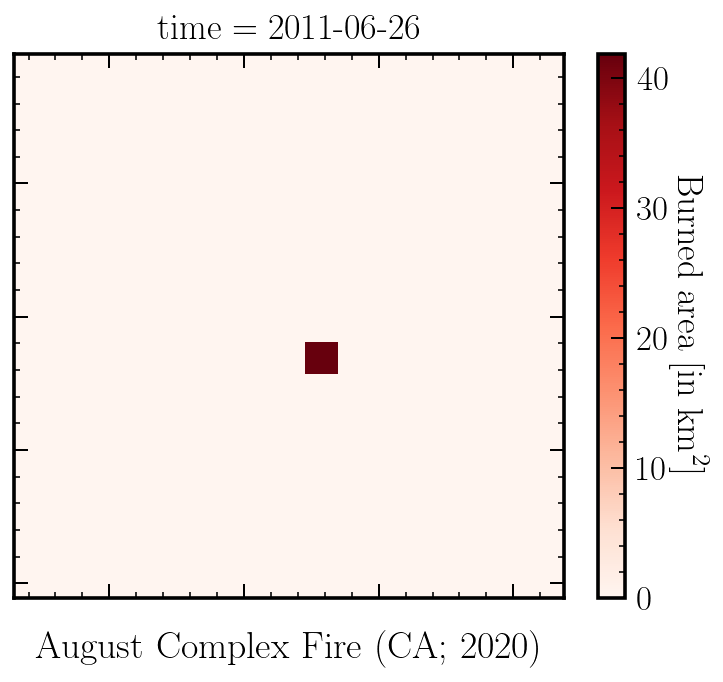

In [19]:
ind= 105739853 #wf1: 105739853 #acf2: 214182885 #acf1: 213957050 
n_grid = 9
cellwidth= 12000
days_arr = np.arange(-5, 16, 1, dtype=float) #acf2: np.arange(-7, 10, 1, dtype=float) #

fig, ax = plt.subplots()

# Create a dummy plot for the colorbar
subset = forest_xarr.sel(time=forest_df.loc[ind].time + timedelta(days=days_arr[0]), 
                         Y=(forest_xarr.Y < forest_df.loc[ind].Y + n_grid*cellwidth) & (forest_xarr.Y > forest_df.loc[ind].Y - n_grid*cellwidth), 
                         X=(forest_xarr.X < forest_df.loc[ind].X + n_grid*cellwidth) & (forest_xarr.X > forest_df.loc[ind].X - n_grid*cellwidth), method= 'nearest')
im = subset.plot(ax=ax, cmap=plt.cm.Reds, add_colorbar=False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel(ylabel= r'Burned area [in ${\rm km}^2$]', rotation= 270, labelpad= 20, fontsize= 18)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

# Define the update function
def update(day):
    ax.clear()
    subset = forest_xarr.sel(time=forest_df.loc[ind].time + timedelta(days=day), 
                             Y=(forest_xarr.Y < forest_df.loc[ind].Y + n_grid*cellwidth) & (forest_xarr.Y > forest_df.loc[ind].Y - n_grid*cellwidth), 
                             X=(forest_xarr.X < forest_df.loc[ind].X + n_grid*cellwidth) & (forest_xarr.X > forest_df.loc[ind].X - n_grid*cellwidth), method= 'nearest')
    im = subset.plot(ax=ax, cmap=plt.cm.Reds, add_colorbar=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('August Complex Fire (CA; 2020)')
    ax.set_ylabel('')
    return im,

# Create the animation
ani = FuncAnimation(fig, update, frames=days_arr, repeat=False, blit=True)
HTML(ani.to_html5_video())
#ani.save('../plots/walllowfire_animation.gif', writer='PillowWriter', fps= 2, dpi= 300) #augcompfire

### Timeseries modeling

In [ ]:
forest_xarr_ur= xarray.open_dataarray('../data/12km/forest_burned_area_2002-2021_12km.nc') 
forest_xarr= forest_xarr_ur.sel(time= forest_xarr_ur.time.isin(pd.date_range(start= '2002-06-19', end= '2020-09-01', freq= 'D'))).resample(time= '3D').sum().sel(time= sm_data.date.values)
forest_df= forest_xarr.to_dataframe('fire').reset_index()

Text(0, 0.5, 'Burned area (in ${\\rm km}^2$)')

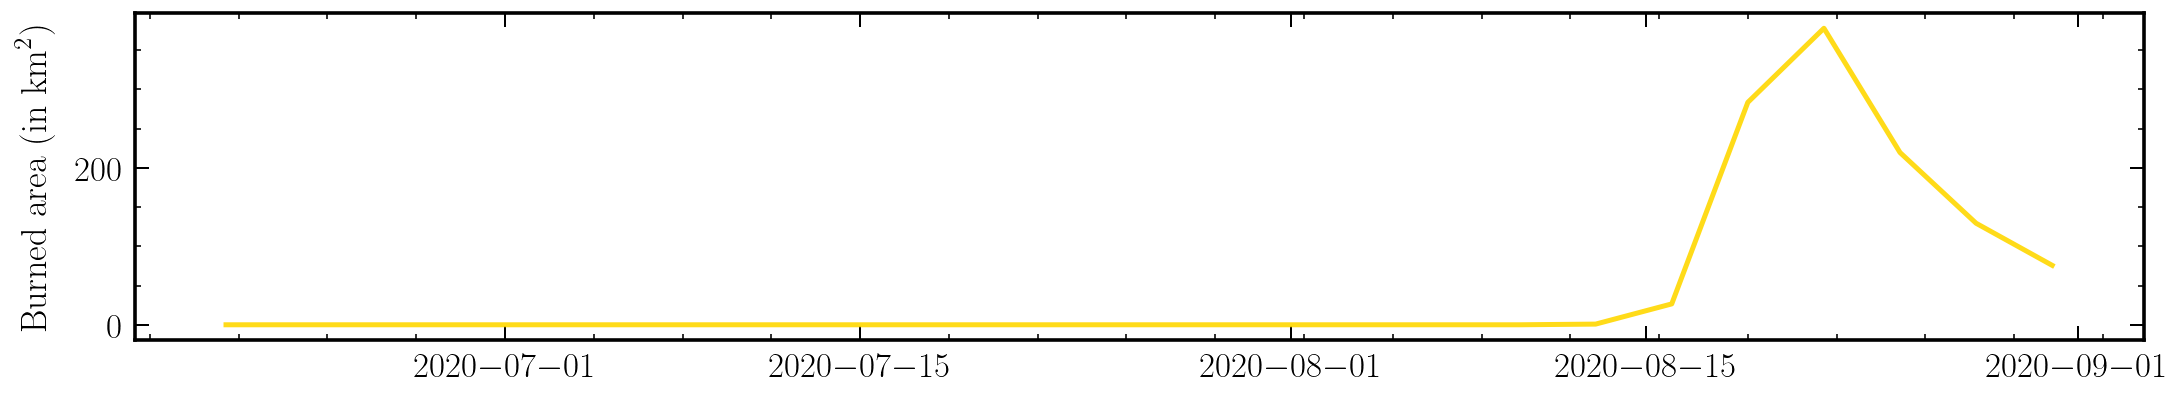

In [33]:
ind= 47308644 #47308644
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 18), periods= 25, freq= '3D').values, \
                    forest_xarr.sel(time= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 18), periods= 25, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X).values, color= 'gold')
ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 18)
#plt.savefig('../plots/fire_2020.pdf', bbox_inches='tight', dpi= 200);

Text(0, 0.5, 'Soil moisture ($m^3 /m^3$)')

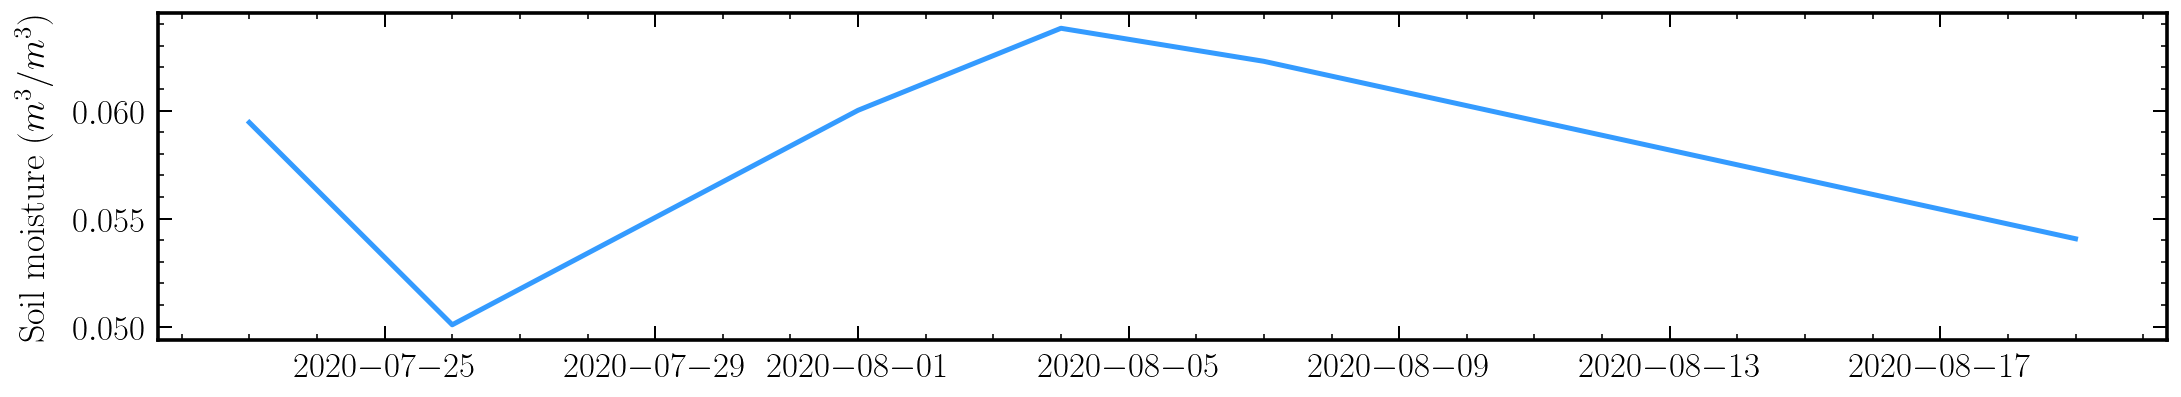

In [267]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), \
    sm_data.sel(date= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X).interpolate_na(dim= 'date'), color= 'dodgerblue')
ax.set_ylabel(r'Soil moisture ($m^3 /m^3$)', fontsize= 18)
#plt.savefig('../plots/sm_2020.pdf', bbox_inches='tight', dpi= 200);

Text(0, 0.5, 'Tmax (in C)')

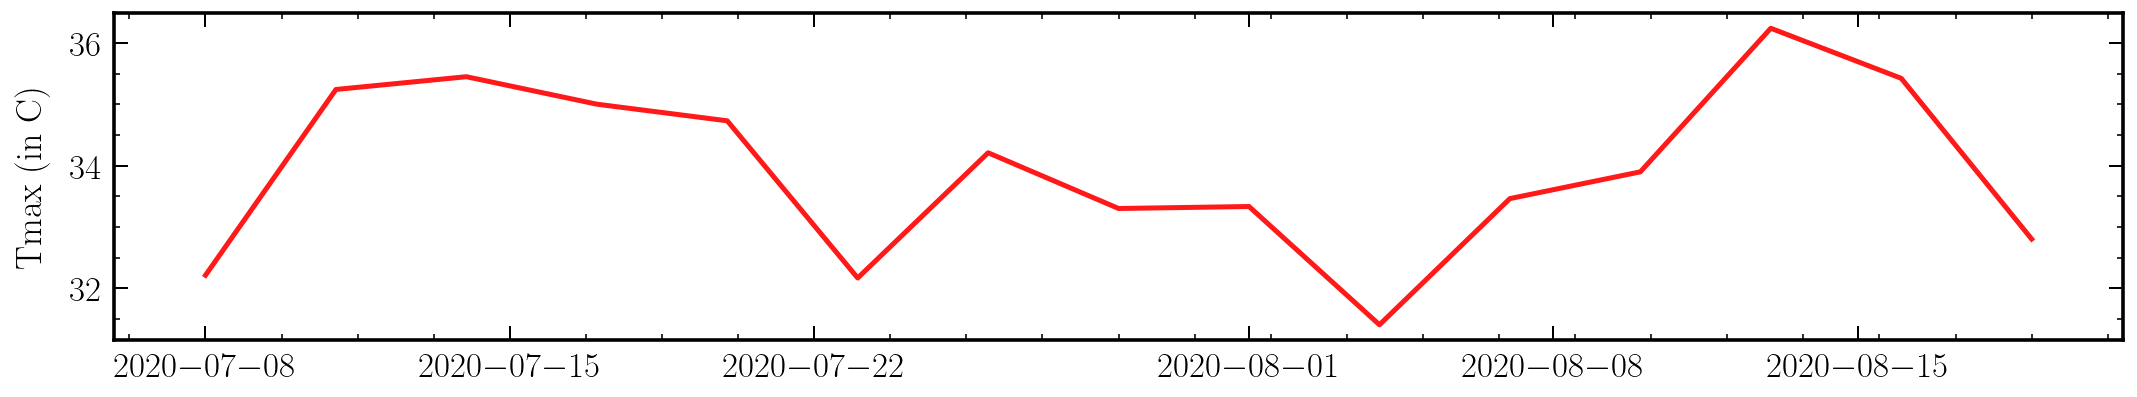

In [251]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), \
                    tmax_data.sel(time= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'red')
ax.set_ylabel('Tmax (in C)', fontsize= 18)
#plt.savefig('../plots/tmax_2020.pdf', bbox_inches='tight', dpi= 200);

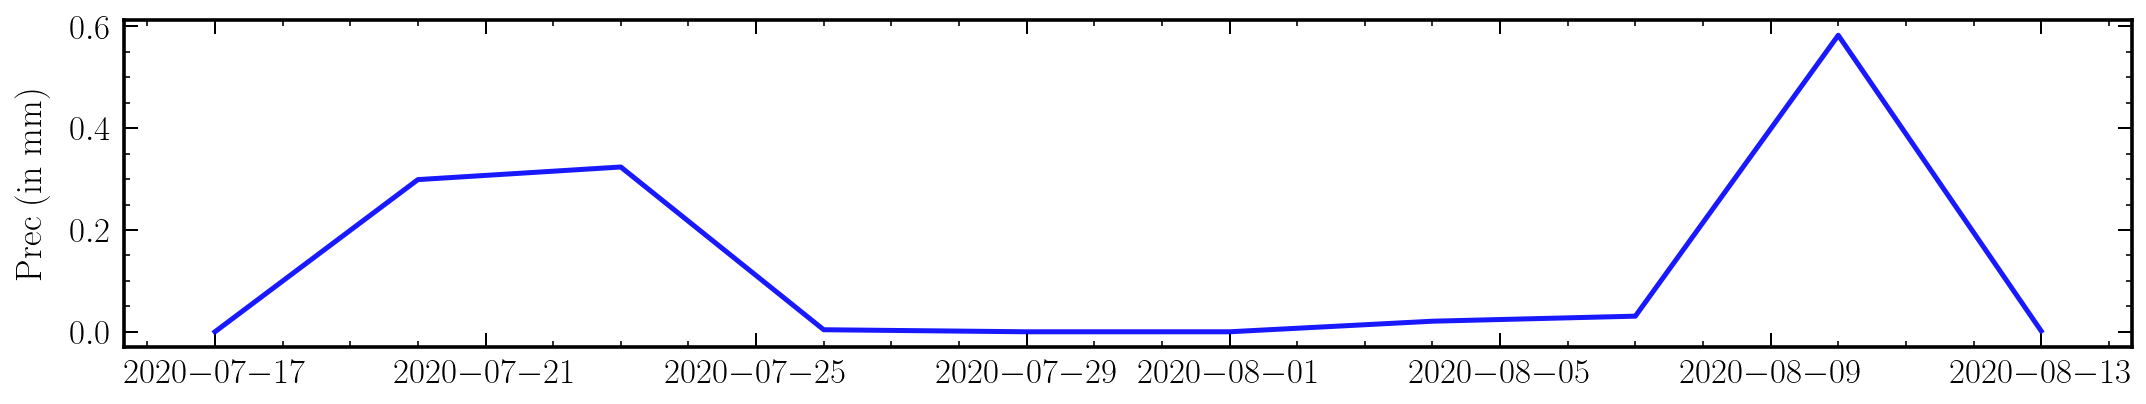

In [218]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), \
                    prec_data.sel(time= pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'blue')
ax.set_ylabel('Prec (in mm)', fontsize= 18)
plt.savefig('../plots/prec_2020.pdf', bbox_inches='tight', dpi= 200);

Text(0, 0.5, 'VPD (in hPa)')

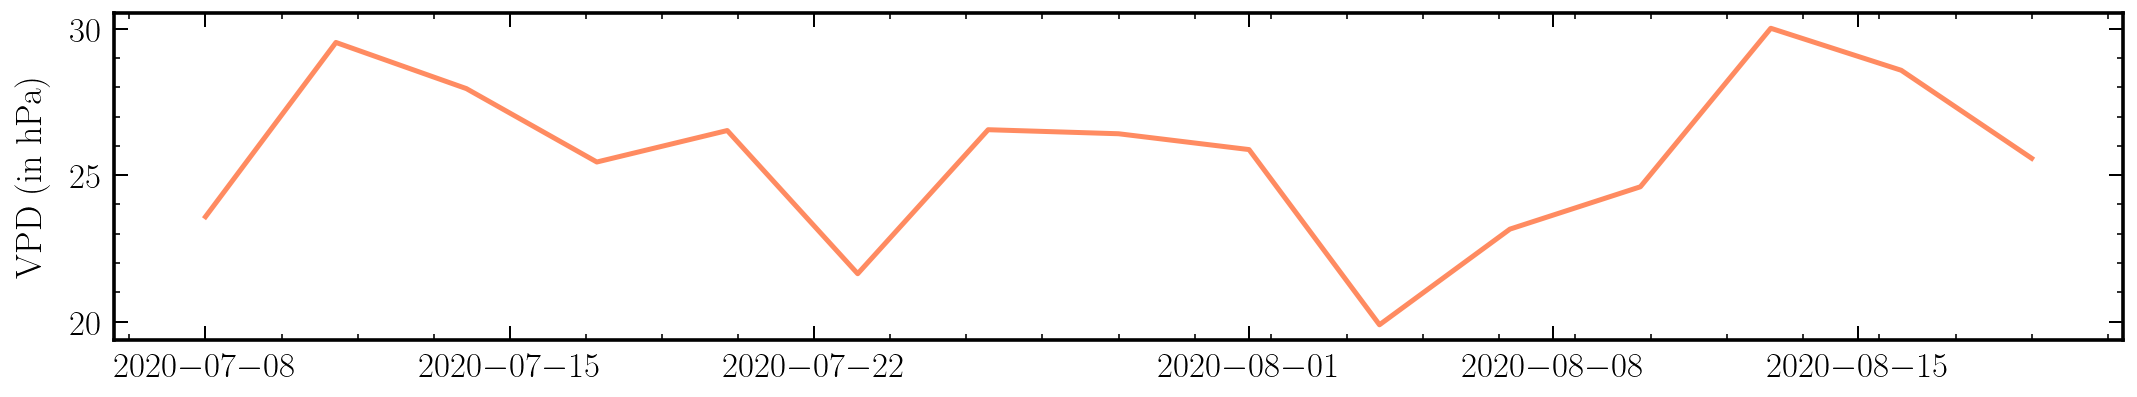

In [252]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), \
                    vpd_data.sel(time= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'coral')
ax.set_ylabel('VPD (in hPa)', fontsize= 18)
#plt.savefig('../plots/vpd_2020.pdf', bbox_inches='tight', dpi= 200);

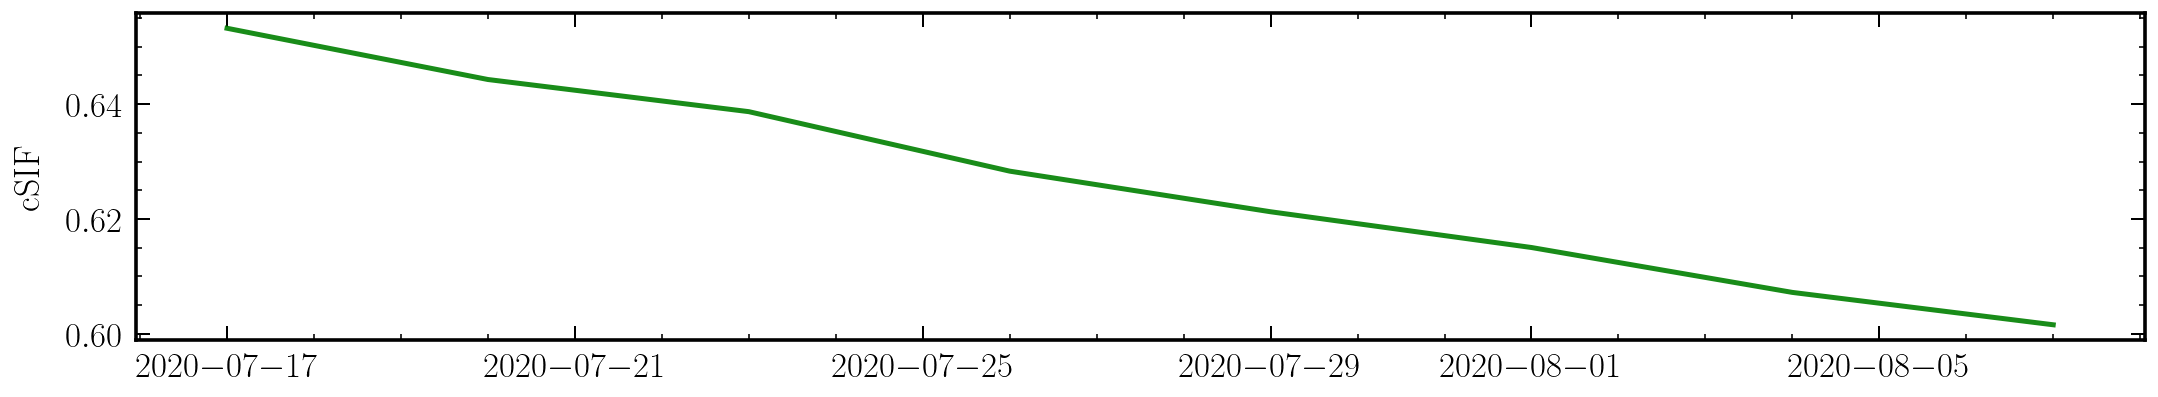

In [216]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), \
                    csif_data.sel(time= pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'green')
ax.set_ylabel('cSIF', fontsize= 18)
plt.savefig('../plots/csif_2020.pdf', bbox_inches='tight', dpi= 200);